In [1]:
import pandas as pd
import numpy as np
import gc
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
# LORENZ.DAT
data = pd.read_table('data/mgdata.dat', header=None)

# scaling
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
data = np.array(data).flatten()

In [10]:
# create d-dimensional data
t, d = 14, 3
lagged = []

for i in range(0, d+1):
    lagged.append(np.roll(data, -t*i)[:-t*d])
    
lagged = np.array(lagged).T
lagged.shape
#unlagged = data[:-t]
#lagged = np.roll(data, -t)[:-t]

(1145, 4)

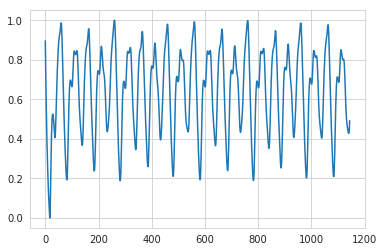

In [51]:
plt.plot(lagged[:, 0])

In [11]:
df = pd.DataFrame(lagged)

In [12]:
df.head()

,0,1,2,3
0,0.896118,0.070076,0.525132,0.608678
1,0.791781,0.044346,0.521811,0.656167
2,0.697372,0.021066,0.512557,0.700000
3,0.611948,0.000000,0.498523,0.739873
4,0.534652,0.024891,0.480707,0.775948


In [13]:
x = df[df.columns[0:-1]]
y = df[df.columns[-1]]

x = np.array(x)
y = np.array(y)

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

In [37]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4,
                                                    random_state=42, shuffle=False)

In [49]:
clf = MLPRegressor(hidden_layer_sizes=(20, 3), activation='relu',
                   solver='adam', random_state=None, verbose=True)
clf.fit(X_train, y_train)

Iteration 1, loss = 0.13391698
Iteration 2, loss = 0.13203636
Iteration 3, loss = 0.13015947
Iteration 4, loss = 0.12831315
Iteration 5, loss = 0.12646445
Iteration 6, loss = 0.12465954
Iteration 7, loss = 0.12287288
Iteration 8, loss = 0.12110365
Iteration 9, loss = 0.11935265
Iteration 10, loss = 0.11763538
Iteration 11, loss = 0.11592676
Iteration 12, loss = 0.11423571
Iteration 13, loss = 0.11259413
Iteration 14, loss = 0.11096538
Iteration 15, loss = 0.10933820
Iteration 16, loss = 0.10775654
Iteration 17, loss = 0.10617722
Iteration 18, loss = 0.10464297
Iteration 19, loss = 0.10311620
Iteration 20, loss = 0.10160966
Iteration 21, loss = 0.10013110
Iteration 22, loss = 0.09865819
Iteration 23, loss = 0.09720925
Iteration 24, loss = 0.09579013
Iteration 25, loss = 0.09438798
Iteration 26, loss = 0.09300961
Iteration 27, loss = 0.09165015
Iteration 28, loss = 0.09029999
Iteration 29, loss = 0.08899437
Iteration 30, loss = 0.08769587
Iteration 31, loss = 0.08642005
Iteration 32, los

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(40, 3), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False)

In [50]:
test = clf.predict(X_test)
clf.score(X_test, y_test)

-0.10883108153913734

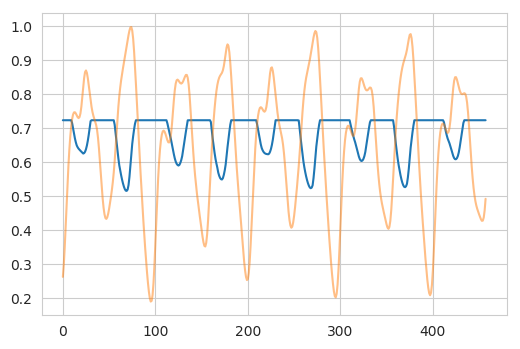

In [48]:
plt.figure(dpi=100)
plt.plot(test)
plt.plot(X_test[:, 0], alpha=0.5)